# Comparing Graph Embedding Spaces

## Clone repo (will overwrite local changes)

In [ ]:
%cd /content/
!rm -rf hgcn
!git clone https://github.com/elipugh/hgcn.git
%cd /content/hgcn

/content
Cloning into 'hgcn'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 643 (delta 3), reused 8 (delta 3), pack-reused 635
Receiving objects: 100% (643/643), 15.30 MiB | 42.81 MiB/s, done.
Resolving deltas: 100% (414/414), done.
/content/hgcn


## Notebook Setup

In [ ]:
%cd /content/hgcn

/content/hgcn


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 17.3MB 200kB/s 
     |████████████████████████████████| 5.4MB 42.6MB/s 
     |████████████████████████████████| 676.9MB 26kB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 1.7MB 65.3MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
  Created wheel for networkx: filename=networkx-2.2-py2.py3-none-any.whl size=1527323 sha256=41ef74813e383b1ed98530c1e5a8e23cfa1f1a304c00d9c352e7735c7a0ca99f
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built networkx
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.19.9 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.19.9 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, b

In [ ]:
%env HGCN_HOME=/content/hgcn
%env LOG_DIR=/content/hgcn/logs
# %env PYTHONPATH=/content/hgcn:$PYTHONPATH
%env DATAPATH=/content/hgcn/data
# %env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda-9.0/lib64

env: HGCN_HOME=/content/hgcn
env: LOG_DIR=/content/hgcn/logs
env: DATAPATH=/content/hgcn/data


## Utilities

In [ ]:
from experiment import run_experiment
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import sys

In [ ]:
def plot(arr,step=1):
  plt.clf()
  xs = [i*step for i in range(len(arr))]
  plt.plot(xs,arr)
  plt.show()

def show_training(histories, diff, save=False):
    plt.clf()
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(22, 11))
    h = deepcopy(histories[0])
    if h["task"] == "nc":
        metrics = ["loss", "acc", "f1"]
    elif h["task"] == "lp":
        metrics = ["loss", "roc", "ap"]
    for i,data in enumerate(["train", "val"]):
        for j,metric in enumerate(metrics):
            n = data + "_" + metric
            title = " ".join([h["model"].upper(), h["dataset"].title(), h["task"].upper(), ":", "d={}".format(h["dim"]), data.title(), metric.upper()])
            ax[i][j].set_title(title)
            for history in histories:
                ys = history[n]
                if data == "val":
                    xs = [i*history["eval_freq"] for i in range(len(ys))]
                else:
                    xs = [i for i in range(len(ys))]
                l = str(history[diff])
                if diff == "mix_frac":
                    m = history[diff]
                    l = f"    {100*m[0]:5.1f}%    {100*m[1]:5.1f}%    {100*m[2]:5.1f}%"
                ax[i][j].plot(xs,ys,label=l)
            if (data=="val") and (j in [1,2]):
                ax[i][j].set_ylim(ymin=0.65-j*.15)
            title = "% : Hyperboloid    Euclidean     Poincare" if (diff=="mix_frac") else diff
            if metric == 'loss':
                ax[i][j].legend(title=title, prop={'family': 'monospace'}, loc=1)
            else:
                ax[i][j].legend(title=title, prop={'family': 'monospace'}, loc=4)

    if save:
        n = "training_"
        n += history["model"] + "_"
        n += history["dataset"] + "_"
        n += diff
        plt.savefig(n, dpi=300)
    plt.show()


def compare(histories, save=False):
    plt.clf()
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    for i,metric in enumerate(["loss", "roc", "ap"]):
        n = metric
        ax[i].set_title("Test "+ n)
        for j,manifold in enumerate(["PoincareBall", "Euclidean", "Hyperboloid"]):
            dims = [2, 4, 8, 16, 32, 64]
            xs = []
            ys = []
            for k,dim in enumerate(dims):
                try:
                    ys += [(histories[(manifold,dim)])["test_"+metric]]
                    xs += [k]
                except:
                    pass
            ax[i].plot(xs,ys,label=manifold)
        ax[i].set_xticklabels([0, 2, 4, 8, 16, 32, 64])
        ax[i].legend(title="Manifold")
        ax[i].set_ylim(ymin=0)


    if save:
        n = "dimension_comp"
        plt.savefig(n)
    plt.show()


## Train Models on Cora

### Test different dims of PoincareBall and plot

In [ ]:
histories = []
for dim in [4,8,16]:
    history = run_experiment("HGCN", "PoincareBall", dim, cuda=0, log_freq=50)
    histories += [history]
    print()

show_training(histories, diff="dim", save=True)

### Test different manifolds with same dim and plot

In [ ]:
histories = []
for manifold in ["PoincareBall", "Euclidean", "Hyperboloid"]:
    history = run_experiment("HGCN", manifold, 32, cuda=0, log_freq=50)
    histories += [history]

show_training(histories, diff="manifold", save=True)

### Try every combo of manifold and dim then plot test metrics

In [ ]:
# Shortcut to the cell below:
import pickle
with open('histories.pkl', 'rb') as fn:
    histories = pickle.load(fn)

In [ ]:
histories = {}
for manifold in ["PoincareBall", "Euclidean", "Hyperboloid"]:
    for dim in [2, 4, 8, 16, 32, 64]:
        try:
            history = run_experiment("HGCN", manifold, dim, cuda=-1, log_freq=50)
            histories[(manifold,dim)] = history
        except:
            print("\n\n", manifold, dim, "failed\n\n")

In [ ]:
compare(histories, save=True)

## Random Plots

<Figure size 432x288 with 0 Axes>

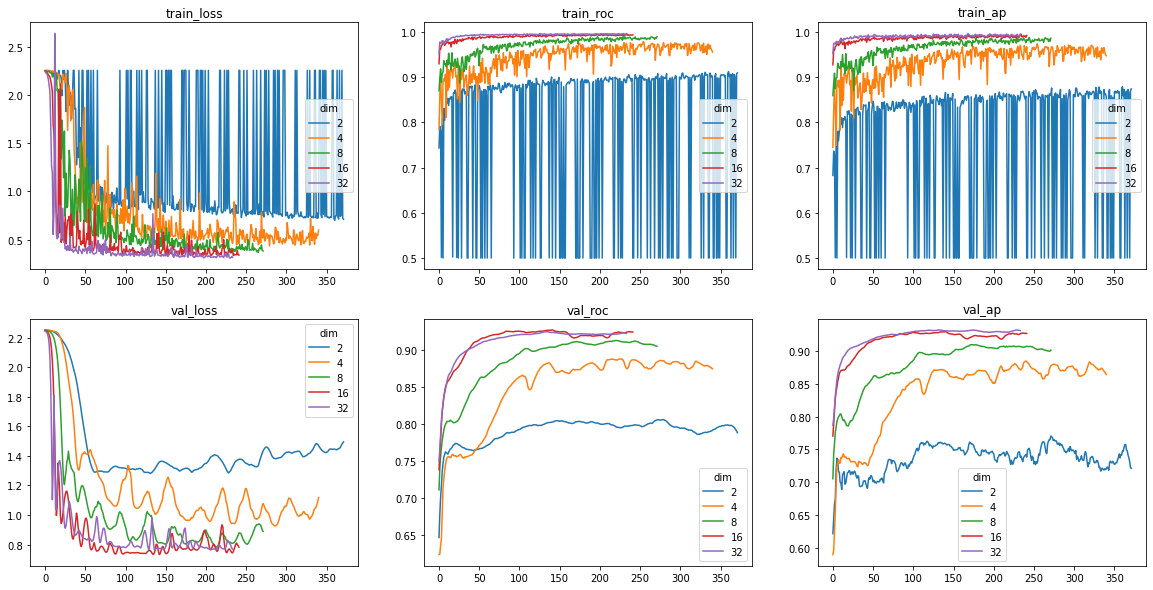

In [ ]:
dims = [2,4,8,16,32]
mhist = [histories[("PoincareBall",d)] for d in dims]
show_training(mhist, diff="dim")

<Figure size 432x288 with 0 Axes>

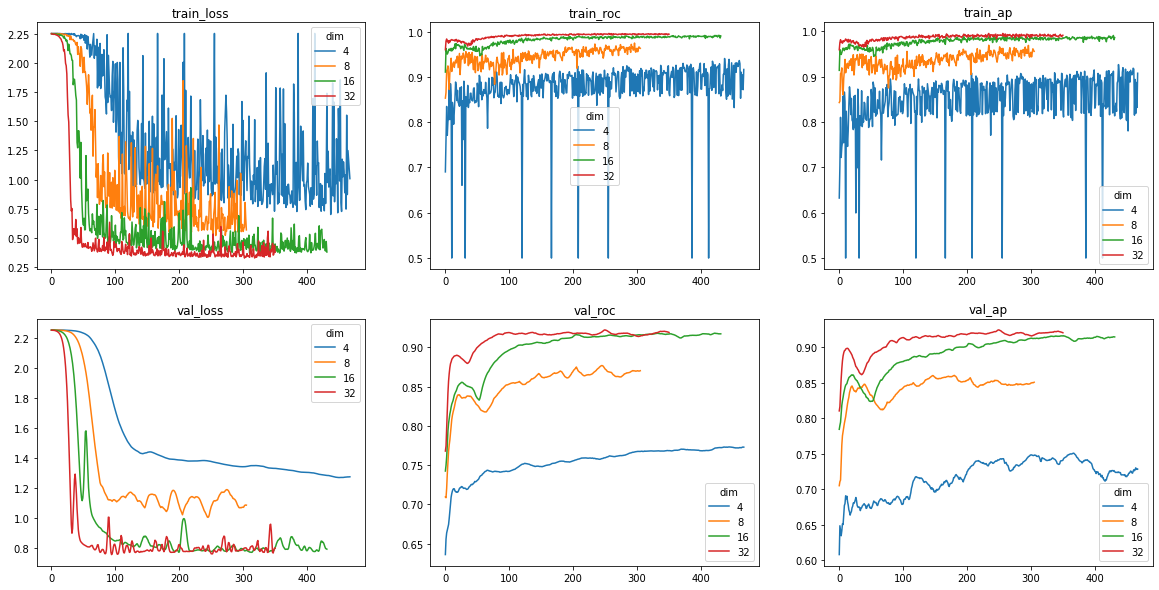

In [ ]:
dims = [4,8,16,32]
mhist = [histories[("Hyperboloid",d)] for d in dims]
show_training(mhist, diff="dim")

<Figure size 432x288 with 0 Axes>

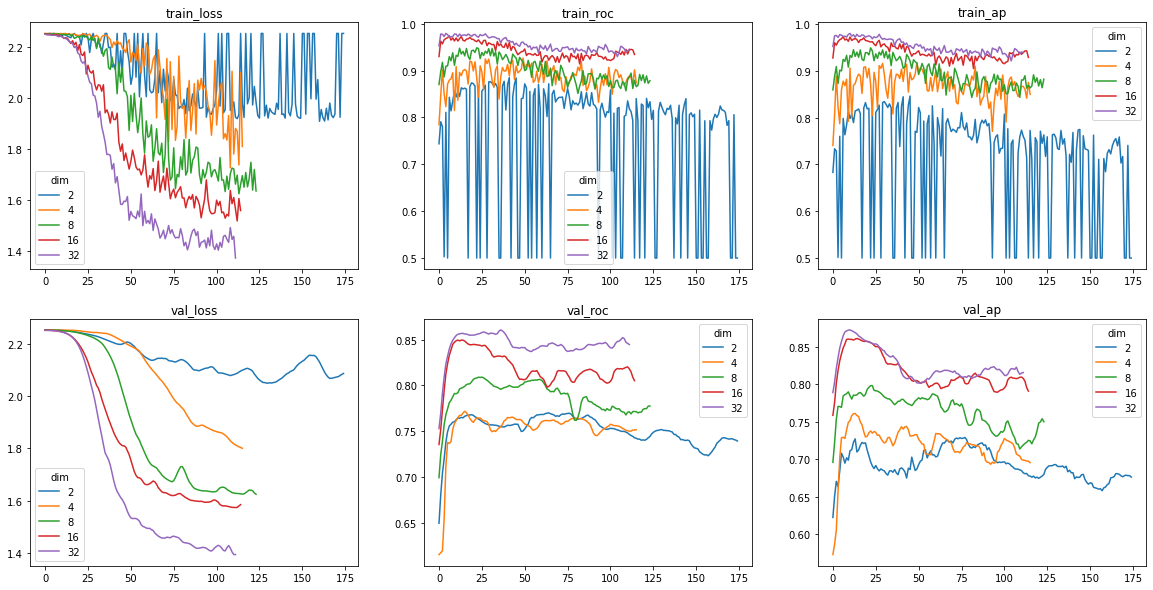

In [ ]:
dims = [2,4,8,16,32]
mhist = [histories[("Euclidean",d)] for d in dims]
show_training(mhist, diff="dim")

<Figure size 432x288 with 0 Axes>

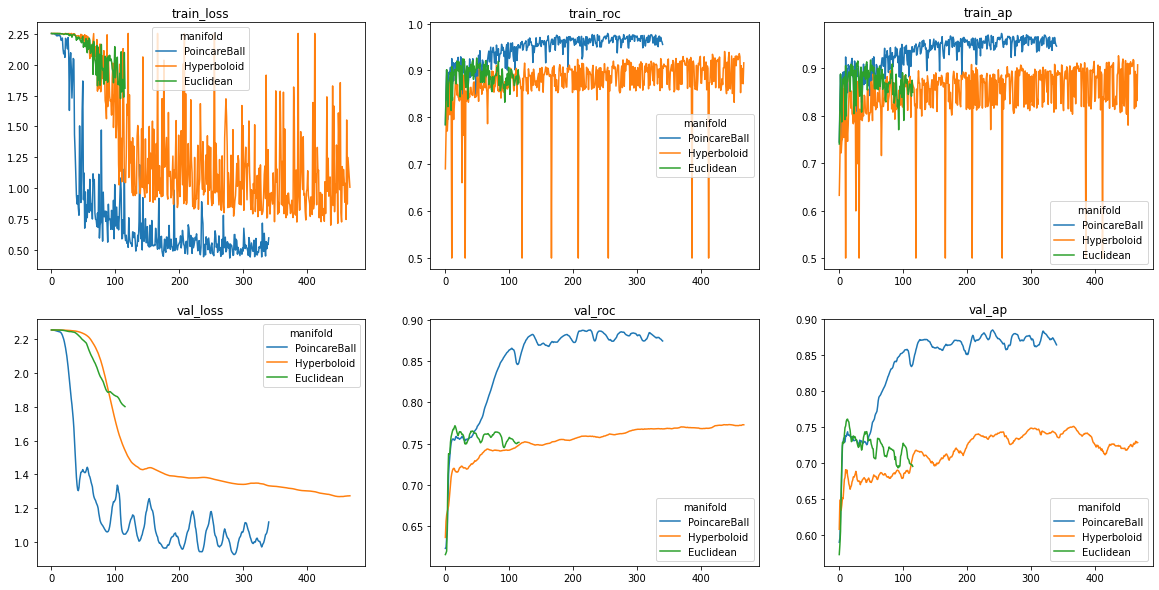

In [ ]:
manifolds = ["PoincareBall", "Hyperboloid", "Euclidean"]
mhist = [histories[(m,4)] for m in manifolds]
show_training(mhist, diff="manifold")

<Figure size 432x288 with 0 Axes>

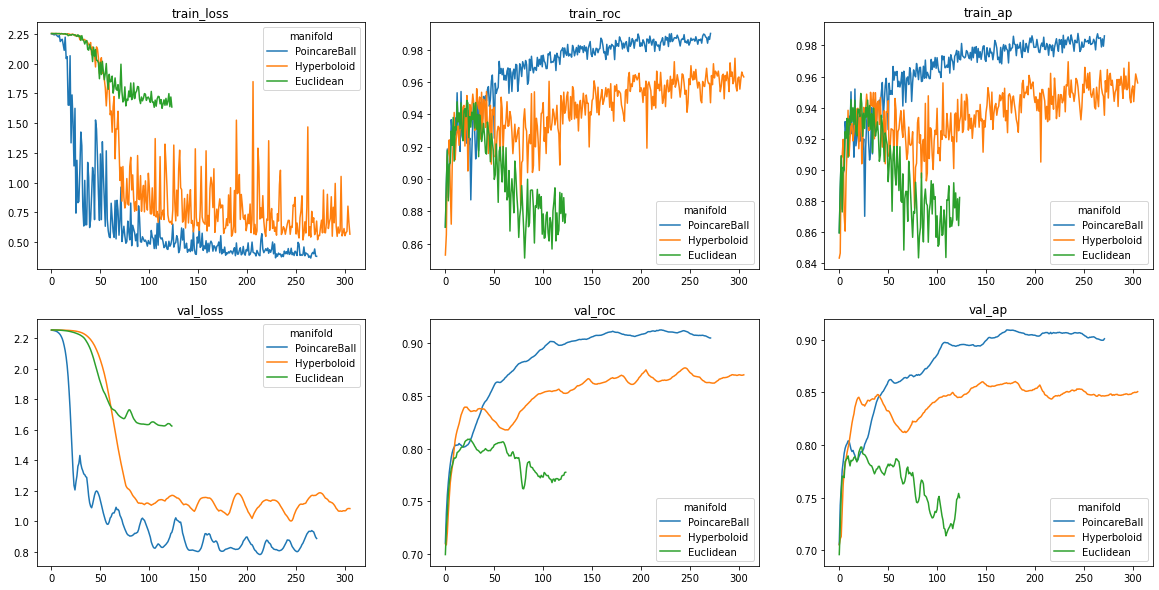

In [ ]:
manifolds = ["PoincareBall", "Hyperboloid", "Euclidean"]
mhist = [histories[(m,8)] for m in manifolds]
show_training(mhist, diff="manifold")

<Figure size 432x288 with 0 Axes>

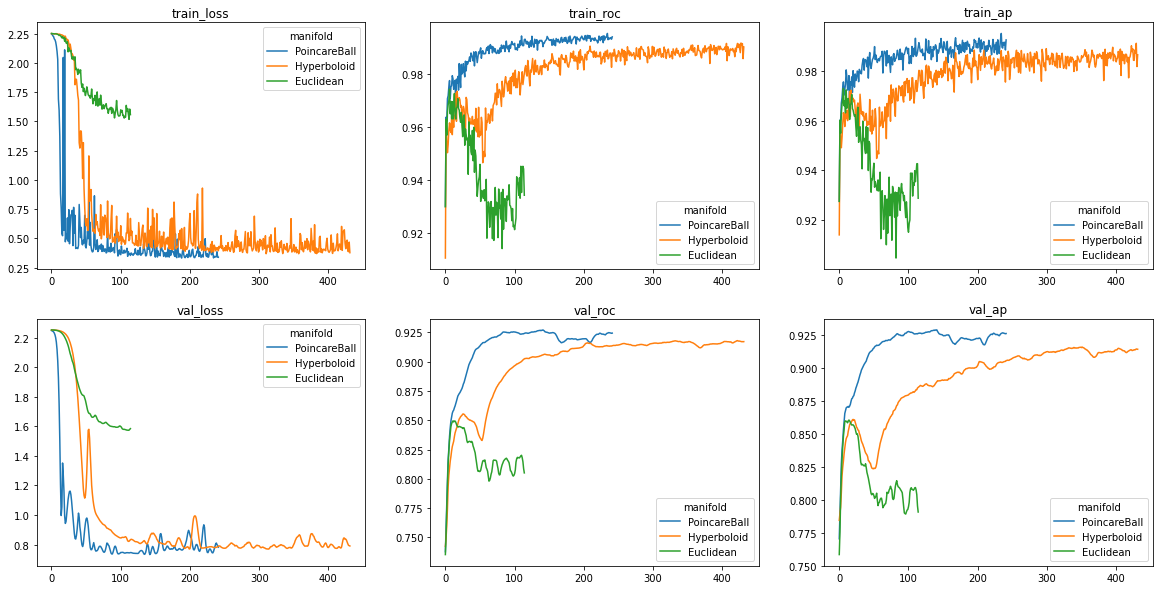

In [ ]:
manifolds = ["PoincareBall", "Hyperboloid", "Euclidean"]
mhist = [histories[(m,16)] for m in manifolds]
show_training(mhist, diff="manifold")

<Figure size 432x288 with 0 Axes>

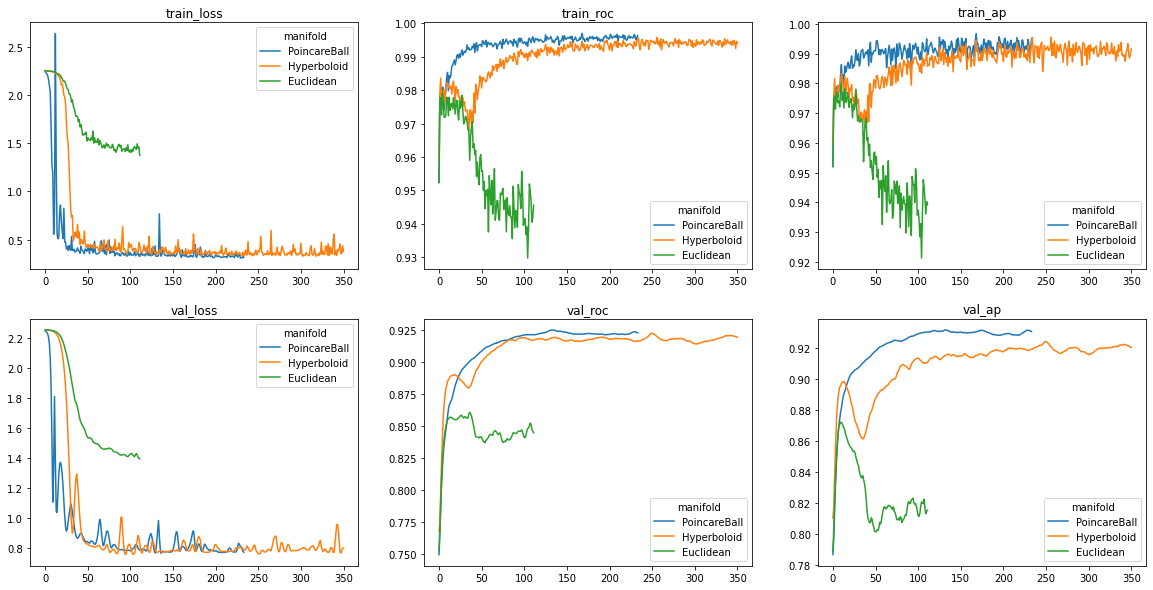

In [ ]:
manifolds = ["PoincareBall", "Hyperboloid", "Euclidean"]
mhist = [histories[(m,32)] for m in manifolds]
show_training(mhist, diff="manifold")

## Mixture Experiments

In [ ]:
histories = []
# d=40
lrs = [0.05, 0.02, 0.05, 0.004, 0.02, 0.005, 0.02, 0.01, 0.01]
# d=20
lrs = [0.01, 0.01, 0.01, 0.001, 0.02, 0.001, 0.01, 0.01, 0.01]
dc = [1000, 1000, 1000, 200, 1000, 200, 100, 1000, 1000]
mfs = [
    [0.333,0.333,0.333],
    [0.5, 0.5, 0],
    [0.5, 0, 0.5],
    [0, 0.5, 0.5],
    [0.9, 0.1, 0],
    [0, 0.1, 0.9],
    [1,   0,   0],
    [0,   1,   0],
    [0,   0,   1]
]
cuda = [0]*9

# lrs = lrs[:3]
# dc = dc[:3]
# mfs = mfs[:3]

for i in range(len(lrs)):
    mf = mfs[i]
    history = run_experiment("HGCN", "Mixture", 20, cuda=cuda[i], log_freq=10, mixed_fractions=mf, task="lp", lr=lrs[i], lr_reduce_freq=dc[i], clipping=1, normalize_feats=1, dataset = dataset)
    histories += [history]

<Figure size 432x288 with 0 Axes>

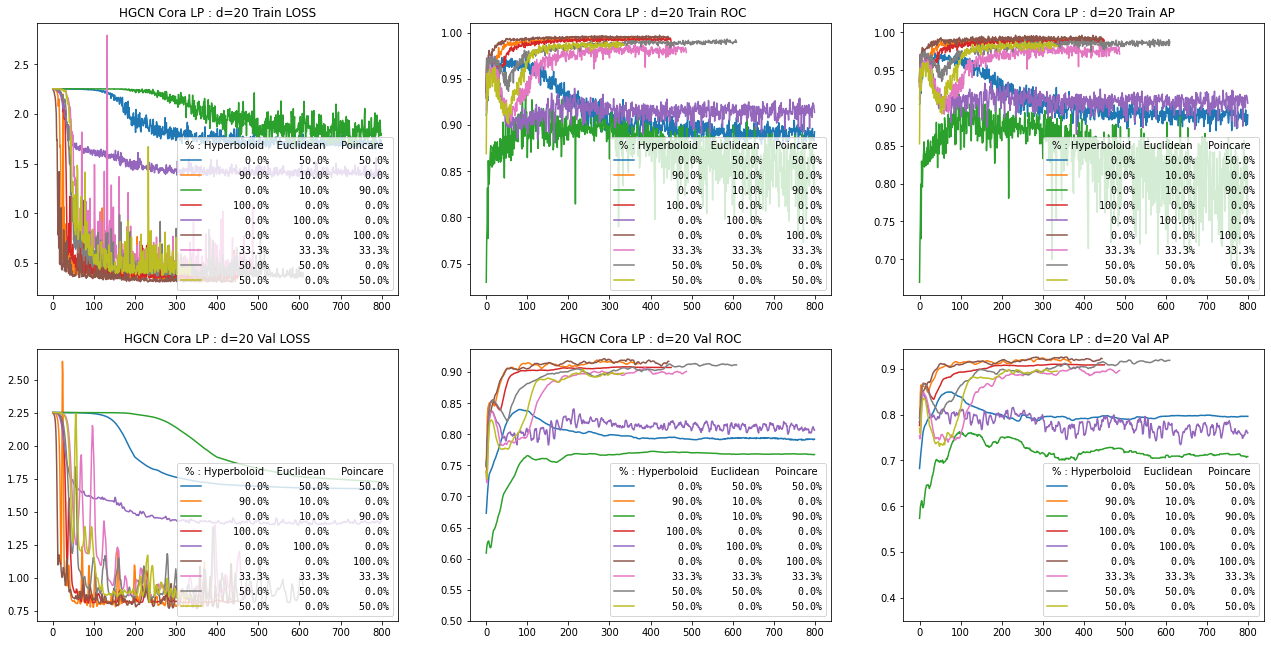

In [ ]:
show_training(histories, "mix_frac", save=True)

In [ ]:
from google.colab import files

n = "training_HGCN_cora_mix_frac.png"
files.download(n) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
histories = []
lrs = [0.01, 0.005]
dc = [1000, 1000, 1000, 1000, 1000, 1000, 1000]
# lrs = lrs[2:]
# dc = dc[2:]
mfs = [[0.333,0.333,0.333]]*7
for i in range(len(lrs)):
    mf = mfs[i]
    history = run_experiment("HGCN", "Mixture", 20, cuda=0, log_freq=10, mixed_fractions=mf, task="lp", lr=lrs[i], lr_reduce_freq=dc[i], normalize_feats=0.1, clipping=.5)
    histories += [history]

In [ ]:
!nvidia-smi

Fri Nov 13 22:41:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |   1311MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
##record: 0-6 is dim 20 runs, for graphing


histories = []
# d=40
lrs = [0.05, 0.02, 0.05, ]
      #  0.004, 0.02, 0.005, 0.02, 0.01, 0.01]
d=20
lrs = [0.01, 0.01, 0.01, 0.0001, 0.001, 0.0001, 0.01, 0.01, 0.01]
dc = [1000, 1000, 1000, 100, 1000, 100, 100, 1000, 1000]
mfs = [
    [0.333,0.333,0.333],
    [0.5, 0.5, 0],
    [0.5, 0, 0.5],
    [0, 0.5, 0.5],
    [0.9, 0.1, 0],
    [0, 0.1, 0.9],
    [1,   0,   0],
    [0,   1,   0],
    [0,   0,   1]
]
cuda = [0]*9

dims = [20, 40]

dataset_task = [('pubmed', 'nc'), ('disease_nc', 'nc'), ('cora', 'lp'), ('airport', 'lp')]

# lrs = lrs[:3]
# dc = dc[:3]
# mfs = mfs[:3]
for dataset, task in dataset_task:
    for i in range(len(lrs)):
        mf = mfs[i]
        for dim in dims:
            history = run_experiment("HGCN", "Mixture", dim, cuda=cuda[i], log_freq=10, mixed_fractions=mf, task=task, lr=lrs[i], lr_reduce_freq=dc[i], clipping=1, normalize_feats=1, dataset = dataset)
            histories += [history]

In [ ]:
# show_training(histories_pubmed_nc, "mix_frac", save=False)

print()
for history in histories:
    print(history['task'], ',', history['dataset'], ',', history['dim'], ',', history['mix_frac'], ',',history['test_loss'], ',', history['test_acc'],',', history['test_f1'])

In [ ]:
histories_disease_nc = []
# d=40
lrs = [0.05, 0.02, 0.05, ]
      #  0.004, 0.02, 0.005, 0.02, 0.01, 0.01]
d=20
lrs = [0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01]
dc = [1000, 1000, 1000, 200, 1000, 200, 100, 1000, 1000]
mfs = [
    [0.333,0.333,0.333],
    [0.5, 0.5, 0],
    [0.5, 0, 0.5],
    # [0, 0.5, 0.5],
    [0.9, 0.1, 0],
    # [0, 0.1, 0.9],
    [1,   0,   0],
    [0,   1,   0],
    [0,   0,   1]
]
cuda = [0]*9


dataset_task = [('disease_nc', 'nc')]

# lrs = lrs[:3]
# dc = dc[:3]
# mfs = mfs[:3]
for dataset, task in dataset_task:
    for i in range(len(lrs)):
        mf = mfs[i]
        history = run_experiment("HGCN", "Mixture", 20, cuda=cuda[i], log_freq=10, mixed_fractions=mf, task=task, lr=lrs[i], lr_reduce_freq=dc[i], clipping=1, normalize_feats=1, dataset = dataset)
        histories += [history]

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:33.3%  Euclidean:33.3%  PoincareBall:33.3%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20084
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.5469 train_acc: 0.9158 train_f1: 0.0000 time: 0.0419s
INFO:root:Epoch: 0010 val_loss: 0.7291 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.4209 train_acc: 0.9158 train_f1: 0.0000 time: 0.0414s
INFO:root:Epoch: 0020 val_loss: 0.9658 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.3918 train_acc: 0.9158 train_f1: 0.0000 time: 0.0411s
INFO:root:Epoch: 0030 val_loss: 1.1213 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040 l

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:50.0%  Euclidean:50.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20084
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.5465 train_acc: 0.9158 train_f1: 0.0000 time: 0.0303s
INFO:root:Epoch: 0010 val_loss: 0.7293 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.4213 train_acc: 0.9158 train_f1: 0.0000 time: 0.0296s
INFO:root:Epoch: 0020 val_loss: 0.9615 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.3918 train_acc: 0.9158 train_f1: 0.0000 time: 0.0298s
INFO:root:Epoch: 0030 val_loss: 1.1184 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040 lr

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:50.0%  Euclidean:0.0%  PoincareBall:50.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20084
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.5463 train_acc: 0.9158 train_f1: 0.0000 time: 0.0422s
INFO:root:Epoch: 0010 val_loss: 0.7295 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.4208 train_acc: 0.9158 train_f1: 0.0000 time: 0.0397s
INFO:root:Epoch: 0020 val_loss: 0.9662 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.3917 train_acc: 0.9158 train_f1: 0.0000 time: 0.0398s
INFO:root:Epoch: 0030 val_loss: 1.1195 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040 lr

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.001  decay:200
INFO:root:Hyperboloid:0.0%  Euclidean:50.0%  PoincareBall:50.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20064
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.001 train_loss: 0.6926 train_acc: 0.6939 train_f1: 0.1612 time: 0.0191s
INFO:root:Epoch: 0010 val_loss: 0.6933 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.001 train_loss: 0.6727 train_acc: 0.7032 train_f1: 0.1120 time: 0.0183s
INFO:root:Epoch: 0020 val_loss: 0.6939 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.001 train_loss: 0.6503 train_acc: 0.6939 train_f1: 0.1089 time: 0.0191s
INFO:root:Epoch: 0030 val_loss: 0.6956 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.02  decay:1000
INFO:root:Hyperboloid:90.0%  Euclidean:10.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20084
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.02 train_loss: 0.4200 train_acc: 0.9158 train_f1: 0.0000 time: 0.0284s
INFO:root:Epoch: 0010 val_loss: 0.9659 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.02 train_loss: 0.4229 train_acc: 0.9158 train_f1: 0.0000 time: 0.0291s
INFO:root:Epoch: 0020 val_loss: 1.2203 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.02 train_loss: 0.3904 train_acc: 0.9158 train_f1: 0.0000 time: 0.0296s
INFO:root:Epoch: 0030 val_loss: 1.0094 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040 lr

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.001  decay:200
INFO:root:Hyperboloid:0.0%  Euclidean:10.0%  PoincareBall:90.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20064
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.001 train_loss: 0.6926 train_acc: 0.6939 train_f1: 0.1612 time: 0.0197s
INFO:root:Epoch: 0010 val_loss: 0.6933 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.001 train_loss: 0.6727 train_acc: 0.7032 train_f1: 0.1120 time: 0.0189s
INFO:root:Epoch: 0020 val_loss: 0.6939 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.001 train_loss: 0.6503 train_acc: 0.6939 train_f1: 0.1089 time: 0.0179s
INFO:root:Epoch: 0030 val_loss: 0.6956 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.01  decay:100
INFO:root:Hyperboloid:100.0%  Euclidean:0.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20084
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.5386 train_acc: 0.9158 train_f1: 0.0000 time: 0.0262s
INFO:root:Epoch: 0010 val_loss: 0.7339 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.4202 train_acc: 0.9158 train_f1: 0.0000 time: 0.0265s
INFO:root:Epoch: 0020 val_loss: 0.9711 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.3918 train_acc: 0.9158 train_f1: 0.0000 time: 0.0264s
INFO:root:Epoch: 0030 val_loss: 1.1173 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040 lr:

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:0.0%  Euclidean:100.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20064
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.5248 train_acc: 0.9158 train_f1: 0.0000 time: 0.0044s
INFO:root:Epoch: 0010 val_loss: 0.7454 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.4209 train_acc: 0.9158 train_f1: 0.0000 time: 0.0041s
INFO:root:Epoch: 0020 val_loss: 0.9894 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.3934 train_acc: 0.9158 train_f1: 0.0000 time: 0.0043s
INFO:root:Epoch: 0030 val_loss: 1.1192 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040 lr

INFO:root:HGCN	Mixture	nc	disease_nc
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:0.0%  Euclidean:0.0%  PoincareBall:100.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Num classes: 2
INFO:root:Total number of parameters: 20064
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.5237 train_acc: 0.9158 train_f1: 0.0000 time: 0.0142s
INFO:root:Epoch: 0010 val_loss: 0.7465 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.4194 train_acc: 0.9158 train_f1: 0.0000 time: 0.0145s
INFO:root:Epoch: 0020 val_loss: 1.0082 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.3923 train_acc: 0.9158 train_f1: 0.0000 time: 0.0148s
INFO:root:Epoch: 0030 val_loss: 1.1152 val_acc: 0.5000 val_f1: 0.0000
INFO:root:Epoch: 0040 lr

In [ ]:
histories_cora_lp = []
# d=40
lrs = [0.05, 0.02, 0.05, ]
      #  0.004, 0.02, 0.005, 0.02, 0.01, 0.01]
d=20
lrs = [0.01, 0.01, 0.01, 0.0001, 0.02, 0.0001, 0.01, 0.01, 0.01]
dc = [1000, 1000, 1000, 100, 1000, 100, 100, 1000, 1000]
mfs = [
    [0.333,0.333,0.333],
    [0.5, 0.5, 0],
    [0.5, 0, 0.5],
    [0, 0.5, 0.5],
    [0.9, 0.1, 0],
    [0, 0.1, 0.9],
    [1,   0,   0],
    [0,   1,   0],
    [0,   0,   1]
]
cuda = [0]*9


dataset_task = [ ('cora', 'lp')]

# lrs = lrs[:3]
# dc = dc[:3]
# mfs = mfs[:3]
for dataset, task in dataset_task:
    for i in range(len(lrs)):
        mf = mfs[i]
        history = run_experiment("HGCN", "Mixture", 20, cuda=cuda[i], log_freq=10, mixed_fractions=mf, task=task, lr=lrs[i], lr_reduce_freq=dc[i], clipping=1, normalize_feats=1, dataset = dataset)
        histories_cora_lp += [history]

INFO:root:HGCN	Mixture	lp	cora
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:33.3%  Euclidean:33.3%  PoincareBall:33.3%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 29123
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 2.2526 train_roc: 0.9581 train_ap: 0.9597 time: 0.0971s
INFO:root:Epoch: 0010 val_loss: 2.2531 val_roc: 0.8323 val_ap: 0.8487
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 2.2504 train_roc: 0.9601 train_ap: 0.9614 time: 0.0974s
INFO:root:Epoch: 0020 val_loss: 2.2504 val_roc: 0.8299 val_ap: 0.8285
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 2.2341 train_roc: 0.9372 train_ap: 0.9370 time: 0.0987s
INFO:root:Epoch: 0030 val_loss: 2.2332 val_roc: 0.8030 val_ap: 0.7857
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 2.1152 train_roc: 0.9304 train_ap: 0.9289 time: 0.0943s
INFO:root:Epoch: 0040 val_loss: 2.0763 val_roc: 0.7820 val_ap: 0.7475
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 1.7870 train_roc: 0.9269 train_ap: 0.9259 time: 0.09

INFO:root:HGCN	Mixture	lp	cora
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:50.0%  Euclidean:50.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 29123
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 2.2484 train_roc: 0.9666 train_ap: 0.9683 time: 0.0714s
INFO:root:Epoch: 0010 val_loss: 2.2499 val_roc: 0.8474 val_ap: 0.8685
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 2.2249 train_roc: 0.9687 train_ap: 0.9681 time: 0.0715s
INFO:root:Epoch: 0020 val_loss: 2.2279 val_roc: 0.8537 val_ap: 0.8564
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 2.1462 train_roc: 0.9645 train_ap: 0.9631 time: 0.0708s
INFO:root:Epoch: 0030 val_loss: 2.0743 val_roc: 0.8441 val_ap: 0.8308
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 1.6270 train_roc: 0.9569 train_ap: 0.9572 time: 0.0723s
INFO:root:Epoch: 0040 val_loss: 1.5553 val_roc: 0.8352 val_ap: 0.8154
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.9306 train_roc: 0.9461 train_ap: 0.9471 time: 0.072

INFO:root:HGCN	Mixture	lp	cora
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:50.0%  Euclidean:0.0%  PoincareBall:50.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 29123
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 2.2528 train_roc: 0.9401 train_ap: 0.9420 time: 0.0903s
INFO:root:Epoch: 0010 val_loss: 2.2531 val_roc: 0.8198 val_ap: 0.8356
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 2.2496 train_roc: 0.9462 train_ap: 0.9480 time: 0.0930s
INFO:root:Epoch: 0020 val_loss: 2.2498 val_roc: 0.8108 val_ap: 0.8042
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 2.2369 train_roc: 0.9280 train_ap: 0.9268 time: 0.0908s
INFO:root:Epoch: 0030 val_loss: 2.2227 val_roc: 0.7833 val_ap: 0.7652
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 2.0104 train_roc: 0.9211 train_ap: 0.9184 time: 0.0954s
INFO:root:Epoch: 0040 val_loss: 1.9686 val_roc: 0.7760 val_ap: 0.7366
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 1.1671 train_roc: 0.9227 train_ap: 0.9187 time: 0.092

INFO:root:HGCN	Mixture	lp	cora
INFO:root:Dim:20  lr:0.02  decay:1000
INFO:root:Hyperboloid:90.0%  Euclidean:10.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 29123
INFO:root:Epoch: 0010 lr: 0.02 train_loss: 2.2292 train_roc: 0.9676 train_ap: 0.9686 time: 0.0730s
INFO:root:Epoch: 0010 val_loss: 2.2286 val_roc: 0.8502 val_ap: 0.8620
INFO:root:Epoch: 0020 lr: 0.02 train_loss: 1.3634 train_roc: 0.9639 train_ap: 0.9629 time: 0.0711s
INFO:root:Epoch: 0020 val_loss: 1.1988 val_roc: 0.8459 val_ap: 0.8502
INFO:root:Epoch: 0030 lr: 0.02 train_loss: 0.6552 train_roc: 0.9743 train_ap: 0.9724 time: 0.0718s
INFO:root:Epoch: 0030 val_loss: 1.0105 val_roc: 0.8702 val_ap: 0.8699
INFO:root:Epoch: 0040 lr: 0.02 train_loss: 0.5935 train_roc: 0.9824 train_ap: 0.9798 time: 0.0720s
INFO:root:Epoch: 0040 val_loss: 1.0678 val_roc: 0.8917 val_ap: 0.8863
INFO:root:Epoch: 0050 lr: 0.02 train_loss: 0.4212 train_roc: 0.9853 train_ap: 0.9832 time: 0.072

INFO:root:HGCN	Mixture	lp	cora
INFO:root:Dim:20  lr:0.01  decay:100
INFO:root:Hyperboloid:100.0%  Euclidean:0.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 29123
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 2.2478 train_roc: 0.9675 train_ap: 0.9687 time: 0.0707s
INFO:root:Epoch: 0010 val_loss: 2.2487 val_roc: 0.8479 val_ap: 0.8674
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 2.2116 train_roc: 0.9683 train_ap: 0.9675 time: 0.0706s
INFO:root:Epoch: 0020 val_loss: 2.2161 val_roc: 0.8524 val_ap: 0.8605
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 2.0413 train_roc: 0.9632 train_ap: 0.9622 time: 0.0769s
INFO:root:Epoch: 0030 val_loss: 1.8299 val_roc: 0.8419 val_ap: 0.8383
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 0.8962 train_roc: 0.9623 train_ap: 0.9617 time: 0.0704s
INFO:root:Epoch: 0040 val_loss: 1.6049 val_roc: 0.8499 val_ap: 0.8430
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.5179 train_roc: 0.9767 train_ap: 0.9754 time: 0.0719

INFO:root:HGCN	Mixture	lp	cora
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:0.0%  Euclidean:100.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 29103
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 2.2432 train_roc: 0.9707 train_ap: 0.9706 time: 0.0226s
INFO:root:Epoch: 0010 val_loss: 2.2469 val_roc: 0.8332 val_ap: 0.8470
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 2.1850 train_roc: 0.9646 train_ap: 0.9644 time: 0.0224s
INFO:root:Epoch: 0020 val_loss: 2.1872 val_roc: 0.8312 val_ap: 0.8199
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 1.9694 train_roc: 0.9521 train_ap: 0.9508 time: 0.0229s
INFO:root:Epoch: 0030 val_loss: 1.9709 val_roc: 0.8178 val_ap: 0.7941
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 1.7605 train_roc: 0.9253 train_ap: 0.9252 time: 0.0227s
INFO:root:Epoch: 0040 val_loss: 1.7936 val_roc: 0.7969 val_ap: 0.7899
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 1.6906 train_roc: 0.9054 train_ap: 0.9053 time: 0.023

INFO:root:HGCN	Mixture	lp	cora
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:0.0%  Euclidean:0.0%  PoincareBall:100.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 29103
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 1.7338 train_roc: 0.9755 train_ap: 0.9753 time: 0.0471s
INFO:root:Epoch: 0010 val_loss: 1.8448 val_roc: 0.8304 val_ap: 0.8508
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.4957 train_roc: 0.9808 train_ap: 0.9785 time: 0.0442s
INFO:root:Epoch: 0020 val_loss: 1.1060 val_roc: 0.8571 val_ap: 0.8680
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.4415 train_roc: 0.9874 train_ap: 0.9842 time: 0.0448s
INFO:root:Epoch: 0030 val_loss: 0.9759 val_roc: 0.8762 val_ap: 0.8801
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 0.4305 train_roc: 0.9914 train_ap: 0.9886 time: 0.0455s
INFO:root:Epoch: 0040 val_loss: 0.9027 val_roc: 0.8925 val_ap: 0.8980
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.3796 train_roc: 0.9935 train_ap: 0.9912 time: 0.046

In [ ]:
histories_airport_lp = []
# d=40
# lrs = [0.05, 0.02, 0.05, ]
      #  0.004, 0.02, 0.005, 0.02, 0.01, 0.01]
d=20
lrs = [0.01, 0.01, 0.01, 0.001, 0.01, 0.01, 0.01]
dc = [1000, 1000, 1000, 200, 1000, 200, 100, 1000, 1000]
mfs = [
    [0.333,0.333,0.333],
    [0.5, 0.5, 0],
    [0.5, 0, 0.5],
    [0, 0.5, 0.5],
    # [0.9, 0.1, 0],
    # [0, 0.1, 0.9],
    [1,   0,   0],
    [0,   1,   0],
    [0,   0,   1]
]
cuda = [0]*9


dataset_task = [ ('airport', 'lp')]

# lrs = lrs[:3]
# dc = dc[:3]
# mfs = mfs[:3]
for dataset, task in dataset_task:
    for i in range(len(lrs)):
        mf = mfs[i]
        history = run_experiment("HGCN", "Mixture", 20, cuda=cuda[i], log_freq=10, mixed_fractions=mf, task=task, lr=lrs[i], lr_reduce_freq=dc[i], clipping=1, normalize_feats=1, dataset = dataset)
        histories_airport_lp += [history]

INFO:root:HGCN	Mixture	lp	airport
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:33.3%  Euclidean:33.3%  PoincareBall:33.3%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 703
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 1.2360 train_roc: 0.9468 train_ap: 0.9357 time: 0.1412s
INFO:root:Epoch: 0010 val_loss: 1.8229 val_roc: 0.9066 val_ap: 0.9079
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 2.6741 train_roc: 0.9316 train_ap: 0.9265 time: 0.1351s
INFO:root:Epoch: 0020 val_loss: 1.1134 val_roc: 0.9035 val_ap: 0.9042
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.8563 train_roc: 0.9590 train_ap: 0.9512 time: 0.1428s
INFO:root:Epoch: 0030 val_loss: 1.0426 val_roc: 0.9039 val_ap: 0.9029
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 3.6278 train_roc: 0.9418 train_ap: 0.9346 time: 0.1371s
INFO:root:Epoch: 0040 val_loss: 0.9756 val_roc: 0.9037 val_ap: 0.9019
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.8170 train_roc: 0.9350 train_ap: 0.9260 time: 0.1

INFO:root:HGCN	Mixture	lp	airport
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:50.0%  Euclidean:50.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 703
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.8213 train_roc: 0.9406 train_ap: 0.9346 time: 0.1127s
INFO:root:Epoch: 0010 val_loss: 1.7336 val_roc: 0.8886 val_ap: 0.8998
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 5.5053 train_roc: 0.9362 train_ap: 0.9306 time: 0.1087s
INFO:root:Epoch: 0020 val_loss: 1.5416 val_roc: 0.8899 val_ap: 0.9012
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.7447 train_roc: 0.9530 train_ap: 0.9466 time: 0.1119s
INFO:root:Epoch: 0030 val_loss: 1.5144 val_roc: 0.9006 val_ap: 0.9082
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 9.2850 train_roc: 0.9170 train_ap: 0.9093 time: 0.1144s
INFO:root:Epoch: 0040 val_loss: 1.3951 val_roc: 0.9046 val_ap: 0.9099
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.8234 train_roc: 0.9418 train_ap: 0.9337 time: 0.11

INFO:root:HGCN	Mixture	lp	airport
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:50.0%  Euclidean:0.0%  PoincareBall:50.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 703
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 1.1153 train_roc: 0.9485 train_ap: 0.9381 time: 0.1379s
INFO:root:Epoch: 0010 val_loss: 1.8408 val_roc: 0.9101 val_ap: 0.9117
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 1.4738 train_roc: 0.9513 train_ap: 0.9439 time: 0.1323s
INFO:root:Epoch: 0020 val_loss: 0.9855 val_roc: 0.9101 val_ap: 0.9113
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.6161 train_roc: 0.9543 train_ap: 0.9466 time: 0.1337s
INFO:root:Epoch: 0030 val_loss: 0.9625 val_roc: 0.9117 val_ap: 0.9108
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 4.1415 train_roc: 0.9555 train_ap: 0.9485 time: 0.1295s
INFO:root:Epoch: 0040 val_loss: 0.9566 val_roc: 0.9106 val_ap: 0.9096
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.7014 train_roc: 0.9528 train_ap: 0.9421 time: 0.13

INFO:root:HGCN	Mixture	lp	airport
INFO:root:Dim:20  lr:0.001  decay:200
INFO:root:Hyperboloid:0.0%  Euclidean:50.0%  PoincareBall:50.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 683
INFO:root:Epoch: 0010 lr: 0.001 train_loss: 2.0303 train_roc: 0.9427 train_ap: 0.9313 time: 0.0909s
INFO:root:Epoch: 0010 val_loss: 2.1243 val_roc: 0.9030 val_ap: 0.9055
INFO:root:Epoch: 0020 lr: 0.001 train_loss: 2.0700 train_roc: 0.9537 train_ap: 0.9449 time: 0.0942s
INFO:root:Epoch: 0020 val_loss: 2.1150 val_roc: 0.9033 val_ap: 0.9055
INFO:root:Epoch: 0030 lr: 0.001 train_loss: 2.1525 train_roc: 0.9400 train_ap: 0.9380 time: 0.0923s
INFO:root:Epoch: 0030 val_loss: 2.1048 val_roc: 0.9035 val_ap: 0.9049
INFO:root:Epoch: 0040 lr: 0.001 train_loss: 2.1012 train_roc: 0.9401 train_ap: 0.9342 time: 0.0992s
INFO:root:Epoch: 0040 val_loss: 2.0962 val_roc: 0.9039 val_ap: 0.9054
INFO:root:Epoch: 0050 lr: 0.001 train_loss: 2.0380 train_roc: 0.9491 train_ap: 0.9398 time:

INFO:root:HGCN	Mixture	lp	airport
INFO:root:Dim:20  lr:0.01  decay:1000
INFO:root:Hyperboloid:100.0%  Euclidean:0.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 703
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.7647 train_roc: 0.9432 train_ap: 0.9378 time: 0.1253s
INFO:root:Epoch: 0010 val_loss: 1.7183 val_roc: 0.9024 val_ap: 0.9081
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 1.2632 train_roc: 0.9426 train_ap: 0.9371 time: 0.1274s
INFO:root:Epoch: 0020 val_loss: 1.5681 val_roc: 0.9009 val_ap: 0.9073
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 0.7436 train_roc: 0.9605 train_ap: 0.9536 time: 0.1284s
INFO:root:Epoch: 0030 val_loss: 1.6220 val_roc: 0.9031 val_ap: 0.9090
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 5.0212 train_roc: 0.9462 train_ap: 0.9405 time: 0.1302s
INFO:root:Epoch: 0040 val_loss: 1.5345 val_roc: 0.9073 val_ap: 0.9129
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.6929 train_roc: 0.9460 train_ap: 0.9393 time: 0.12

INFO:root:HGCN	Mixture	lp	airport
INFO:root:Dim:20  lr:0.01  decay:200
INFO:root:Hyperboloid:0.0%  Euclidean:100.0%  PoincareBall:0.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 683
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 2.0062 train_roc: 0.9341 train_ap: 0.9249 time: 0.0604s
INFO:root:Epoch: 0010 val_loss: 1.9445 val_roc: 0.8927 val_ap: 0.8943
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 1.9179 train_roc: 0.9526 train_ap: 0.9442 time: 0.0652s
INFO:root:Epoch: 0020 val_loss: 1.9632 val_roc: 0.8938 val_ap: 0.8930
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 1.8332 train_roc: 0.9553 train_ap: 0.9498 time: 0.0605s
INFO:root:Epoch: 0030 val_loss: 1.9312 val_roc: 0.8956 val_ap: 0.8939
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 1.8264 train_roc: 0.9465 train_ap: 0.9421 time: 0.0601s
INFO:root:Epoch: 0040 val_loss: 1.8741 val_roc: 0.8984 val_ap: 0.8952
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 1.7220 train_roc: 0.9384 train_ap: 0.9316 time: 0.061

INFO:root:HGCN	Mixture	lp	airport
INFO:root:Dim:20  lr:0.01  decay:100
INFO:root:Hyperboloid:0.0%  Euclidean:0.0%  PoincareBall:100.0%
INFO:root:Using: cuda:0
INFO:root:Using seed 1234.
INFO:root:Total number of parameters: 683
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 0.9046 train_roc: 0.9286 train_ap: 0.9206 time: 0.0871s
INFO:root:Epoch: 0010 val_loss: 1.7481 val_roc: 0.8932 val_ap: 0.8986
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 0.5885 train_roc: 0.9539 train_ap: 0.9448 time: 0.0811s
INFO:root:Epoch: 0020 val_loss: 1.6631 val_roc: 0.8976 val_ap: 0.9038
INFO:root:Epoch: 0030 lr: 0.01 train_loss: 1.2200 train_roc: 0.9397 train_ap: 0.9365 time: 0.0841s
INFO:root:Epoch: 0030 val_loss: 1.4945 val_roc: 0.9002 val_ap: 0.9067
INFO:root:Epoch: 0040 lr: 0.01 train_loss: 1.0670 train_roc: 0.9413 train_ap: 0.9352 time: 0.0795s
INFO:root:Epoch: 0040 val_loss: 1.3850 val_roc: 0.9024 val_ap: 0.9073
INFO:root:Epoch: 0050 lr: 0.01 train_loss: 0.6688 train_roc: 0.9490 train_ap: 0.9408 time: 0.081